# Assignment 1

Fit an Hidden Markov Model to the data in DSET1: it is sufficient to focus on a single column of the dataset of your choice (i.e. choose one of the sensors available and focus on analysis that single sensor). Experiment with training  HMMs with two different choices of the emission distribution and confront the results.  Experiment also with HMMs with a varying number of hidden states (e.g. at least 2, 3 and 4) and identify what is the best choice according to your own reasoning.

Once you have identified the best HMM configuration (emissions and number of states), choose a reasonably sized subsequence (e.g. last 25% of the timeseries) and compute the optimal assignement using two methods: i) Viterbi (true optimal) and ii) best state according to the hidden state posterior (very local decision). Then plot the timeseries data highlighting (e.g. with different colours) the hidden state assigned to each timepoint by the Viterbi algorithm and the posterior method.  Discuss the results.

## Data Preprocessing

Interpolation and other strategies to get rid of null values (-200).

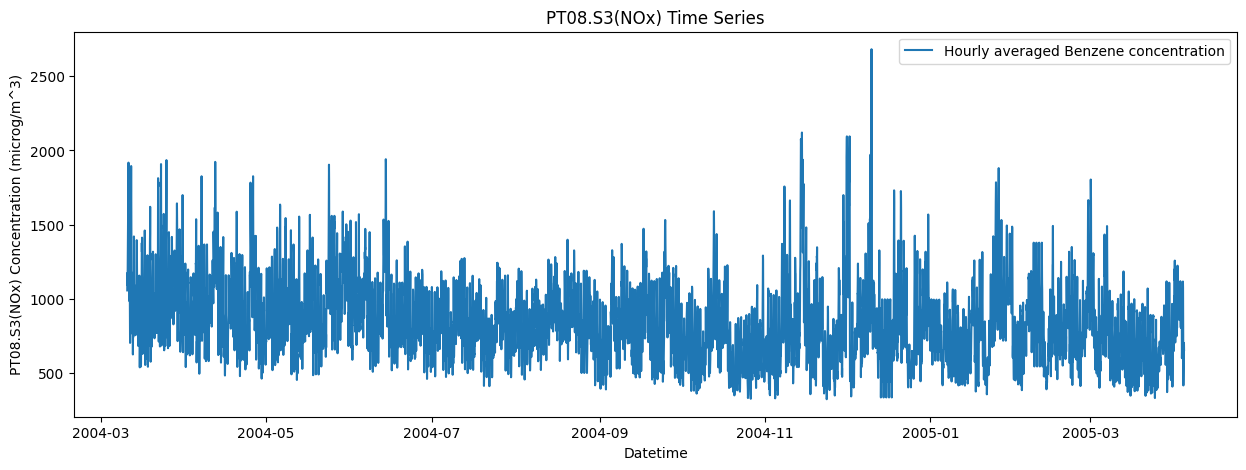

In [ ]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from matplotlib.colors import LogNorm

plt.style.use('default')

df = pd.read_csv(
    'https://raw.githubusercontent.com/cpic29/ISPR/main/AirQualityUCI.csv',
    delimiter=';',
    nrows=9357,
    usecols=['Date', 'Time', 'PT08.S3(NOx)']
)

date_time_format = '%d/%m/%Y %H.%M.%S'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format=date_time_format)

df['PT08.S3(NOx)'] = pd.to_numeric(df['PT08.S3(NOx)'], errors='coerce')

df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].replace(-200, np.nan)
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].interpolate(limit=1)
nan_indices = np.where(df['PT08.S3(NOx)'].isna())[0]
for index in nan_indices:
    prev_time = df.loc[index, 'Datetime'] - pd.Timedelta(hours=24)
    prev_value = df.loc[df['Datetime'] == prev_time, 'PT08.S3(NOx)'].values
    df.loc[index, 'PT08.S3(NOx)'] = prev_value[0]

df.drop(['Date', 'Time'], axis=1, inplace=True)
df.rename(columns={'PT08.S3(NOx)': 'PT08.S3(NOx)'}, inplace=True)

plt.figure(figsize=(15, 5))
plt.plot(df['Datetime'], df['PT08.S3(NOx)'], label='Hourly averaged Benzene concentration')
plt.title('PT08.S3(NOx) Time Series')
plt.xlabel('Datetime')
plt.ylabel('PT08.S3(NOx) Concentration (microg/m^3)')
plt.legend()
plt.show()


## Model Selection and Assessment

In [ ]:
data = df['PT08.S3(NOx)'].values.reshape(-1, 1)
states = [2, 3, 4, 5, 7, 8, 10, 13]

split_point_tr = int(len(data) * 0.8)
X_dev = data[:split_point_tr]
X_test = data[split_point_tr:]
split_point_vl = int(len(X_dev)*0.8)
X_train = data[:split_point_vl]
X_vl = data[split_point_vl:]


In [ ]:
def eval(data, val, states, models, aic, bic, ll, n_iter, n_mix=None, mix=False):
    for n in states:
        if mix:
            model = hmm.GMMHMM(n_components=n, n_mix=n_mix, covariance_type="diag", algorithm="viterbi", n_iter=n_iter, tol=0.1, random_state=43)
        else:
            model = hmm.GaussianHMM(n_components=n, covariance_type='diag', algorithm="viterbi", n_iter=n_iter, tol=0.1, random_state=43)

        model.fit(data)
        score = model.score(val)

        aic.append(model.aic(data))
        bic.append(model.bic(data))
        ll.append(score)

        print(f"Model with {n} states {'and ' + str(n_mix) + ' mixtures' if mix else ''} trained. Converged: {model.monitor_.converged}")

aic_1 = []
aic_2 = []
aic_3 = []

bic_1 = []
bic_2 = []
bic_3 = []

ll_1 =[]
ll_2 = []
ll_3 = []

models_mix3 = []
models_gaus = []

eval(X_train, X_vl, states, models_gaus, aic_1, bic_1, ll_1, 1000)
eval(X_train, X_vl, states, models_mix3, aic_3, bic_3, ll_3, 1000, 3, True)

Model with 2 states  trained. Converged: True
Model with 3 states  trained. Converged: True
Model with 4 states  trained. Converged: True
Model with 5 states  trained. Converged: True
Model with 7 states  trained. Converged: True
Model with 8 states  trained. Converged: True
Model with 10 states  trained. Converged: True
Model with 13 states  trained. Converged: True
Model with 2 states and 3 mixtures trained. Converged: True
Model with 3 states and 3 mixtures trained. Converged: True
Model with 4 states and 3 mixtures trained. Converged: True
Model with 5 states and 3 mixtures trained. Converged: True
Model with 7 states and 3 mixtures trained. Converged: True
Model with 8 states and 3 mixtures trained. Converged: True
Model with 10 states and 3 mixtures trained. Converged: True
Model with 13 states and 3 mixtures trained. Converged: True


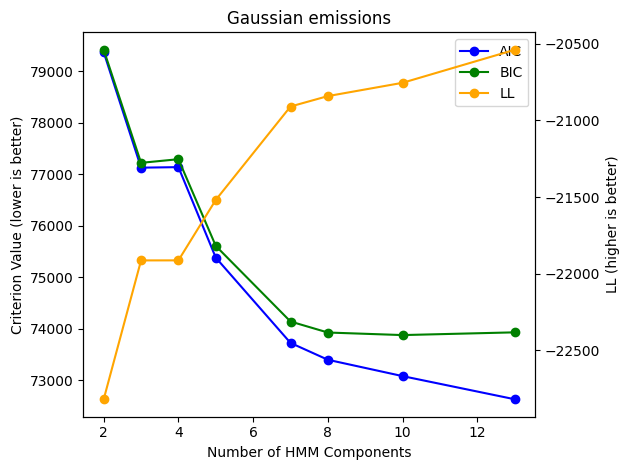

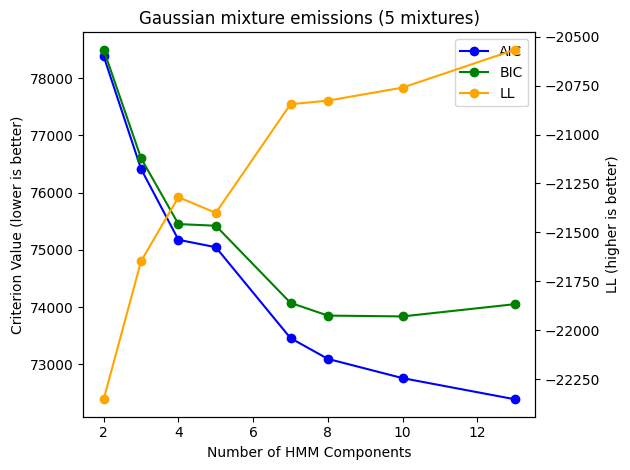

In [ ]:
def plot(states, aic, bic, ll):
    fig, ax = plt.subplots()
    ln1 = ax.plot(states, aic, label="AIC", color="blue", marker="o")
    ln2 = ax.plot(states, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ln3 = ax2.plot(states, ll, label="LL", color="orange", marker="o")

    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Using AIC/BIC for Model Selection")
    ax.set_ylabel("Criterion Value (lower is better)")
    ax2.set_ylabel("LL (higher is better)")
    ax.set_xlabel("Number of HMM Components")
    fig.tight_layout()

    fig.tight_layout()
    return fig, ax, ax2

fig, ax, ax2 = plot(states, aic_1, bic_1, ll_1)
ax.set_title("Gaussian emissions")
plt.show()

fig, ax, ax2 = plot(states, aic_3, bic_3, ll_3)
ax.set_title("Gaussian mixture emissions (5 mixtures)")
plt.show()

As outlined in the assignment, for model selection, different choices for emission distribution and the number of hidden states were explored. Specifically, the emission distributions selected were the Gaussian and a more complex Gaussian mixture with three components. This choice was driven by the nature of the training data, which consists of continuous measurements. These distributions are well-suited for continuous data, especially given that the dataset includes hourly measurements of a pollutant over more than a year.

The Gaussian model, as the simpler of the two, served as a baseline, assuming the emission probabilities from each hidden state were modeled using a single Gaussian distribution. In contrast, the Gaussian mixture model could provide greater flexibility by allowing the emission distribution for each hidden state to consist of multiple Gaussian distributions.


To select the optimal model, several metrics were considered: the Bayesian Information Criterion (BIC), the Akaike Information Criterion (AIC), and the log-likelihood. It is well established that utilizing only log-likelihood for model selection is generally unsuitable as it tends to increase with model complexity, potentially leading to overfitting. Therefore, BIC and AIC were employed to balance model fit against this risk. These metrics were calculated on the training set,  with the BIC imposing a more severe penalty and thus being especially useful for models prone to complexity. Log-likelihood was assessed on the validation set to evaluate how effectively the model generalizes to new data. So, the idea was to choose the model with the highest log likelihood, but the lowest BIC to balance the trade-off between complexity and generalization capability.


Let us examine the graphs that represent different values of these metrics for various emission distributions and numbers of hidden states. It is interesting to note that although the Gaussian model is simpler, it manages to achieve comparable BIC and likelihood results, if not better, than those of the Gaussian mixture. Notably, the range of values for both BIC and likelihood across models with varied distributions closely aligns.

Both models exhibit BIC values that stabilize at 8 hidden states, while for the Gaussian mixture with 3 mixtures, BIC starts to increase after 10 hidden states, indicating that any additional complexity is not justified by the model's likelihood. In contrast, the AIC values exhibits less sensitivity to increases in model complexity. This pattern is indicative of AIC’s milder penalization for additional parameters compared to BIC. Given that BIC incorporates a penalty term that escalates with the logarithm of the dataset size, it more heavily penalizes complexity in larger datasets. Therefore, BIC is often the preferred criterion in scenarios where overfitting is a concern and dataset size is substantial.

Considering these observations and recalling Occam's razor, the model selected as the best has 8 states and a Gaussian emission distribution.


## Best Model

In [ ]:
model = hmm.GaussianHMM(n_components=8, covariance_type='diag', algorithm="viterbi", n_iter=1000, tol=0.1)
model.fit(X_dev)

#Bayesian Information Criterion (BIC)
print(model.bic(X_dev))
#Akaike Information Criterion (AIC)
print(model.aic(X_dev))
#Log Likelihood
print(model.score(X_test))
best_model = hmm.GaussianHMM(n_components=8, covariance_type='diag', algorithm="viterbi", n_iter=1000, tol=0.1)
best_model.fit(data)

#Bayesian Information Criterion (BIC)
print(model.bic(data))
#Akaike Information Criterion (AIC)
print(model.aic(data))

92704.67688577106
92157.94503831961
-11431.611254156687
115586.49938159782
115022.13286118103


After the initial training phase, the model was subsequently trained on a combined set of both training and validation data. This phase was intended to further assess the model's ability to generalize. The evaluation on this extended dataset showed a decrease in BIC and an increase in likelihood performance on the test set, suggesting that the model improved in fitting the data without introducing unnecessary complexity.

The model underwent a final training session utilizing the entire dataset.This comprehensive training was followed by recalculating the BIC and AIC, which showed even lower values than before. This further reduction was a positive indication, suggesting that the enhanced training on the full dataset had likely resulted in a more robust model.

## Viterbi and Posterior Probabilities

In [ ]:
# Calculate the index at which to start the subsequence to get the last 25%
start_index = int(len(data) * 0.75)  # This computes 75% of the length, so we start just after that

# Extract the last 25% of `data` as `subsequence`
subsequence = data[start_index:]

# Extract the datetime index for the last 25%
df.set_index('Datetime', inplace=True)
x_coords = df.index[start_index:]

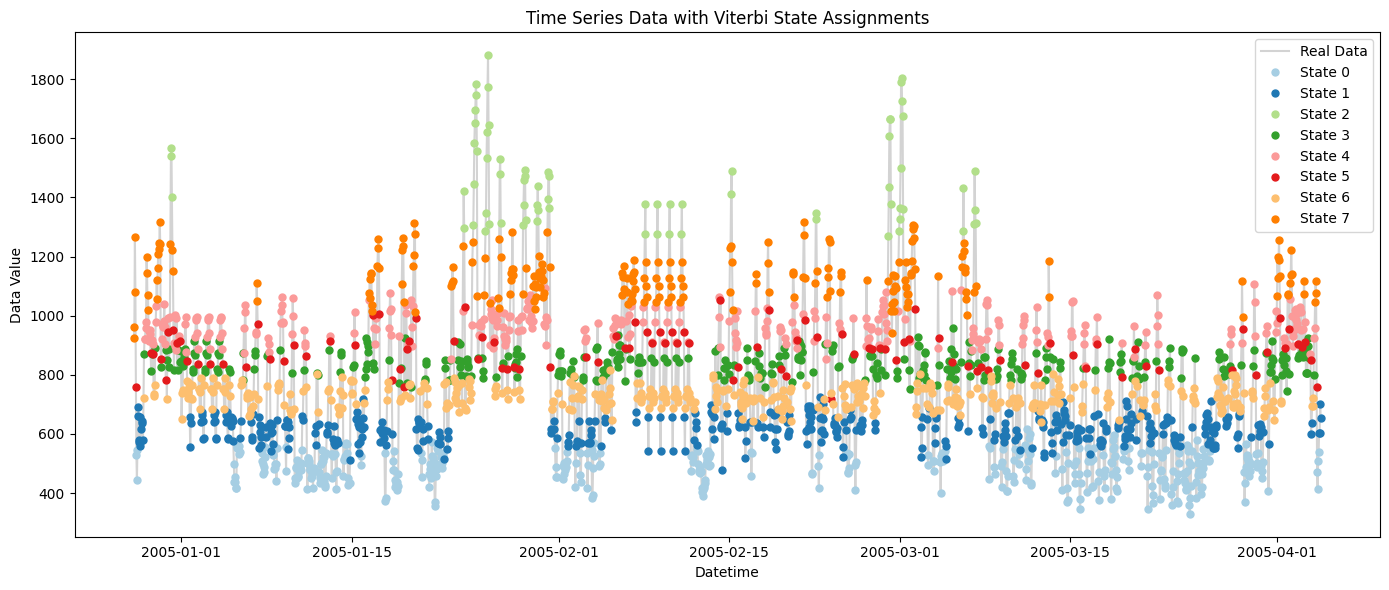

<Figure size 1400x600 with 0 Axes>

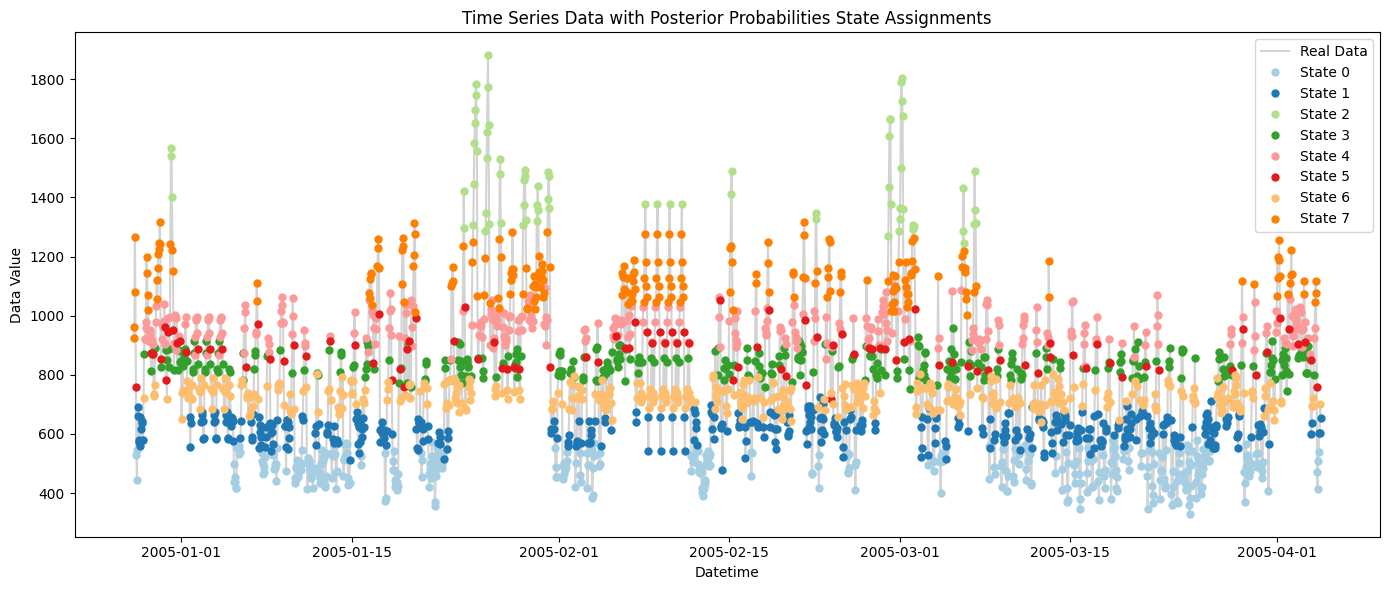

In [ ]:
# Viterbi: predict the most likely sequence of hidden states given the observed data
states_viterbi = best_model.predict(subsequence)

unique_states = np.unique(states_viterbi)

new_palette = 'Paired'

colors = sns.color_palette(new_palette, len(unique_states))

plt.figure(figsize=(14, 6))

plt.plot(x_coords, subsequence, label='Real Data', color='lightgrey')
for i, state in enumerate(unique_states):
    state_mask = states_viterbi == state
    plt.plot(x_coords[state_mask], subsequence[state_mask], marker='o', linestyle='', markersize=5, color=colors[i], label=f'State {state}')

plt.title('Time Series Data with Viterbi State Assignments')
plt.xlabel('Datetime')
plt.ylabel('Data Value')
plt.legend()
plt.tight_layout()
plt.show()

# Compute the posterior probabilities and then take the state with the max probability at each time
posterior_probs = best_model.predict_proba(subsequence)
posterior_states = np.argmax(posterior_probs, axis=1)

plt.figure(figsize=(14, 6))

unique_states = np.unique(posterior_states)

colors = sns.color_palette(new_palette, len(unique_states))

plt.figure(figsize=(14, 6))

plt.plot(x_coords, subsequence, label='Real Data', color='lightgrey')
for i, state in enumerate(unique_states):
    state_mask = posterior_states == state
    plt.plot(x_coords[state_mask], subsequence[state_mask], marker='o', linestyle='', markersize=5, color=colors[i], label=f'State {state}')

plt.title('Time Series Data with Posterior Probabilities State Assignments')
plt.xlabel('Datetime')
plt.ylabel('Data Value')
plt.legend()
plt.tight_layout()
plt.show()

The next step, as indicated by the assignment, was to select a subsequence of the data (the last 25%) and apply to it both the Viterbi algorithm and the posterior probabilities algorithm to compute the optimal state assignment.

From the charts that depict the state assignments by the two methods, we can observe that there are no significant visual differences. Upon precisely calculating the number of different states assigned by the two methods, it emerges that these instances are few.

These results demonstrate that at each time instance, the state with the highest posterior probability coincides with the corresponding state in the sequence that has the highest overall probability, as determined by the Viterbi algorithm.

The similar outcomes from both the Viterbi algorithm and posterior probability assessments indicate strong consistency in state prediction. This suggests that the data at each point in time is highly representative of the underlying state, such that the most probable state for any given time step is also the state that fits best within the optimal sequence across the entire dataset.

## States Analysis

In [ ]:
stats_by_state = {}
m=[]
s=[]

# Loop through each unique state
for state in np.unique(states_viterbi):
    # Extract the segment of data belonging to the current state
    state_data = subsequence[states_viterbi == state]

    # Calculate statistics
    mean = np.mean(state_data)
    median = np.median(state_data)
    variance = np.var(state_data)
    svd = np.sqrt(variance)

    # Store in dictionary
    stats_by_state[state] = {'mean': pd.to_numeric(mean), 'median': pd.to_numeric(median), 'variance': pd.to_numeric(variance)}
    m.append(mean)
    s.append(svd)

df_stats = pd.DataFrame(stats_by_state).T

# Round the numbers for better readability
df_stats = df_stats.round(3)

styled_df = df_stats.style.background_gradient(cmap='Blues') \
                   .highlight_max(color='Blues') \
                   .highlight_min(color='Blues') \
                   .format("{:.2f}") \
                   .set_properties(**{'font-size': '14pt'})

styled_df.set_table_styles([
    {'selector': 'th', 'props': [('font-size', '12pt')]},
    {'selector': 'th.col_heading', 'props': [('font-size', '14pt')]},
    {'selector': 'th.row_heading', 'props': [('font-size', '14pt')]},
])
styled_df

,mean,median,variance
0,484.61,490.00,2701.13
1,615.48,618.00,1669.32
2,1459.07,1413.00,24842.88
3,839.73,840.00,1482.53
4,963.50,962.00,2524.07
5,881.62,888.00,4345.84
6,726.71,726.00,1225.31
7,1132.16,1129.00,5775.73


In the context of environmental data, such as pollutant concentrations, each hidden state in an HMM should ideally correspond to a physically interpretable condition, such as varying levels of pollution. For this dataset, we have identified 8 hidden states that can be categorized as follows:

* States 0, 1, 6 represent low pollution levels: These states are characterized by low mean, median, and variance, suggesting periods of low pollution. This is corroborated by the Viterbi and posterior probability state assignment graphs. These states may correspond to times of reduced industrial activity or traffic, like nighttime.

* States 3, 5, 4 represent medium pollution levels: These states, with their intermediate means and medians and moderate variance, likely reflect normal pollution conditions typically observed during a regular working day.

* States 7, 2 represent high pollution levels: These states, with higher means and medians, denote periods of increased pollutant concentrations, which could be linked to peak traffic hours, for example. They also exhibit high variance, especially state 2.

An additional observation: state 2, that signifies periods with the highest pollution levels, also has a high variance. This implies significant fluctuations in detected pollutant amounts during these periods. There are times when the pollution level is extremely high and others when it is comparatively lower. Nonetheless, on average, this state indicates a higher level of pollution relative to the other states. The high variance indicates that the consistency of this "high pollution" varies substantially.


## Transition probabilities

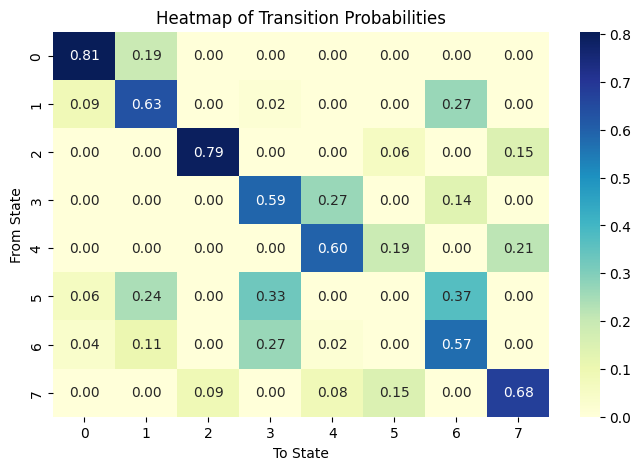

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(best_model.transmat_, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Heatmap of Transition Probabilities')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()

The majority of states exhibit a high probability of self-transition, which indicates that once the system enters one of these states, it is highly likely to remain there for the next observation. States 0, 1, 2, 3, 4, 6, and 7 demonstrate this characteristic, with the highest probabilities being in state 0 (0.81) and state 2 (0.79), suggesting extended periods of consistent pollution levels: if the system is in a state of either very low (0) or very high (2) pollution, there is a high likelihood of staying at that pollution level.

It is noteworthy that state 5 has a zero probability of self-transition. This state has non-zero transition probabilities to states 0, 1, 3 and 6. This indicates that when in state 5, which corresponds to a moderately high pollution level, the system can only transition to a state with lower levels of pollution.

## Discrepancies analysis

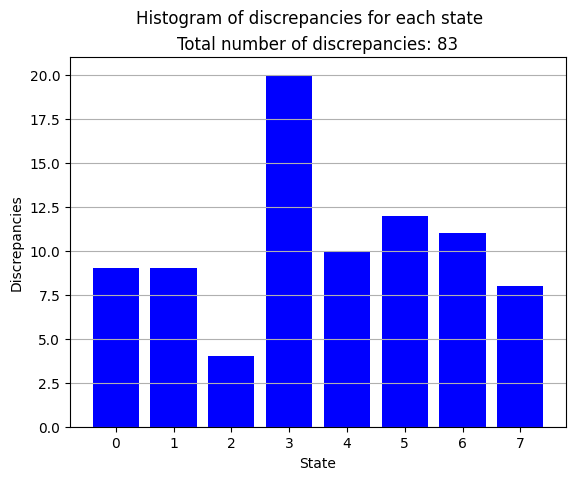

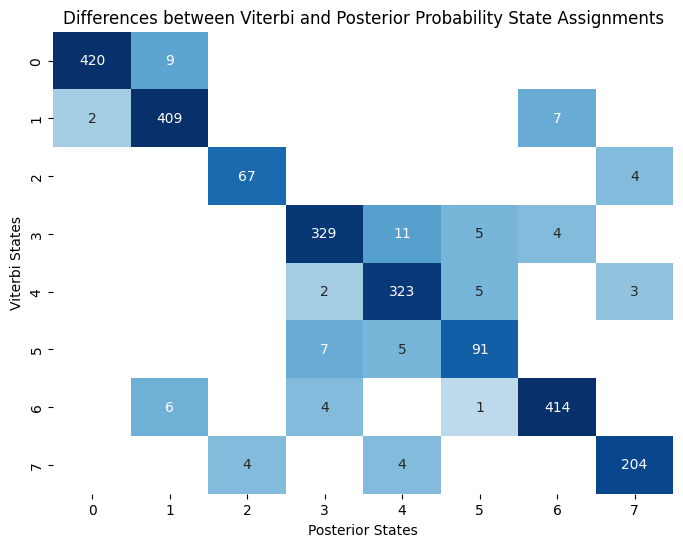

In [ ]:
np.where(states_viterbi != posterior_states)[0]
tot_discrepancies = len(np.where(states_viterbi != posterior_states)[0])

discrepancy =  posterior_states != states_viterbi

unique_states, counts = np.unique(states_viterbi[discrepancy], return_counts=True)

state_counts = dict(zip(unique_states, counts))

plt.bar(state_counts.keys(), state_counts.values(), color='blue')
plt.xlabel('State')
plt.ylabel('Discrepancies')
plt.suptitle('Histogram of discrepancies for each state')
plt.title(f'Total number of discrepancies: {tot_discrepancies}')
plt.xticks(range(8))
plt.grid(axis='y')
plt.show()

total_samples = len(states_viterbi)

confusion_matrix = np.zeros((8, 8))

for viterbi_state, posterior_state in zip(states_viterbi, posterior_states):
    if viterbi_state != posterior_state:
        confusion_matrix[viterbi_state, posterior_state] += 1
    else:
        confusion_matrix[viterbi_state, posterior_state] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, cmap="Blues", annot=True, norm=LogNorm(vmin=0.1, vmax=confusion_matrix.max()), cbar=False, fmt='.0f')
plt.xlabel('Posterior States')
plt.ylabel('Viterbi States')
plt.title('Differences between Viterbi and Posterior Probability State Assignments')
plt.show()


It is worthwhile to further investigate the discrepancies between state assignments to see if they yield any insightful observations.

Upon examining the number of states assigned differently by Viterbi and posterior probabilities, it is interesting to note that the greatest number of discrepancies occur in state 3.

To better understand these discrepancies, we can use a matrix that indicates how often states have been assigned in the same manner and which states have seen changes.

For state 3, Viterbi sometimes identifies it as state 3, whereas posterior probabilities might assign it as states 4, 5, or 6, or vice versa. This variation can be attributed to the close pollution levels among these states. State 6 is lower, and state 5 and 4 are higher in pollution than state 3, but they are all relatively close, which explains the occasional misclassifications.

Upon closer examination of the matrix, we observe that this phenomenon occurs repeatedly. Essentially, when one method diverges from the other in assigning a state, it typically selects the state that the other method would likely choose if it were also to diverge in that instance. Specifically, when the Viterbi algorithm assigns state 0 and there is an inconsistency, the posterior probability typically assigns state 1, and vice versa. Moreover, we also notice that in cases of discrepancies, the differing states are typically closely aligned in terms of pollution levels. This implies that while the exact state assignments may vary between the two methods, they are similar in terms of the underlying pollution level they represent.

The observations suggest that the discrepancies of states assignment between the Viterbi and the posterior probability algorithms primarily occur between states representing adjacent pollution levels. This highlights the nuanced difficulty of discerning between closely related states.

## Conclusions

Hidden Markov Models (HMMs) have proven to be a powerful tool for modeling time series data. However, their application to air pollution data exhibits specific limitations due to inherent assumptions of the model structure. A fundamental assumption of HMMs is that observations are independent. This assumption often does not hold in environmental studies, where pollutant levels frequently exhibit temporal correlations driven by persistent sources and environmental dynamics.

Furthermore, the Markovian assumption that the state at any given time t is influenced solely by the state at time t-1 does not adequately represent long-term dependencies common in environmental data. Influences such as weather patterns, seasonal variations, and other cyclical changes can impact future states beyond the immediate next step, suggesting that a simple first-order Markov process may be insufficient.
